
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling

_Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

---

<img src="https://snag.gy/uvESGH.jpg" alt="drawing" width="800"/>

### $$
\begin{eqnarray*}
\textbf{Fun Fact:  } \text{Word Clouds} &\neq& \text{Data Science}
\end{eqnarray*}
$$

[If you want to generate a word cloud in the shape of something **for art only**, check here.](https://medium.com/hackernoon/what-real-fake-news-says-about-obamas-presidency-4bf42be71ff1)

## Learning Objectives
---

- Extract features from unstructured text by fitting and transforming with `CountVectorizer` and `TfidfVectorizer`.
- Describe how CountVectorizers and TF-IDFVectorizers work.
- Understand `stop_words`, `max_features`, `min_df`, `max_df`, and `ngram_range`.
- Implement `CountVectorizer` and `TfidfVectorizer` in a spam classification model.
- Use `GridSearchCV` and `Pipeline` with `CountVectorizer`.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Reminder of the Data Science Process
1. Define problem.
2. Gather data.
3. Explore data.
    - Yes, we can still do EDA with text data!
    - We also have to pre-process our text data to prepare it for modeling.
4. Model with data.
5. Evaluate model.
6. Answer problem.

# Introduction to Text Feature Extraction

The models we've learned, like linear regression, logistic regression, and k-nearest neighbors, take in an `X` and a `y` variable.
- `X` is a matrix/dataframe of real numbers.
- `y` is a vector/series of real numbers.

Text data (also called natural language data) is not already organized as a matrix or vector of real numbers. We say that this data is **unstructured**.

> This lesson will focus on how to transform our unstructured text data into a numeric `X` matrix.

# Spam Classification Model

One common application of NLP is predicting "spam" vs. "ham," or "spam" vs. "not spam."

Can we predict real vs. promotional texts just based on what is written?

> This data set was taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

In [6]:
# Read in data.
spam = pd.read_csv('./data/SMSSpamCollection',
                 sep='\t',
                 names=['label', 'message'])

# Check out first five rows.


In [7]:
spam

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Basic terminology

---

- A collection of text is a **document**. 
    - You can think of a document as a row in your feature matrix.
- A collection of documents is a **corpus**. 
    - You can think of your full dataframe as the corpus.

<details><summary>In this specific example, what is a document?</summary>
    
- Each text message in our data set is one document. 
- There are 5,572 documents in our corpus.
</details>

## Let's get our data
---

Convert ham/spam into binary labels:
- 0 for ham
- 1 for spam

In [8]:
# Create label column
spam['label'] = spam['label'].map({'ham':0, 'spam':1})
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
spam.label.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

Let's set up our data for modeling:
- `X` will be the `message` column. **NOTE**: `CountVectorizer` requires a vector, so make sure you set `X` to be a `pandas` Series, **not** a DataFrame.
- `y` will be the `label` column

In [11]:
X = spam.message
y = spam.label

In [12]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

In [13]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
X_train

1634      Yesterday its with me only . Now am going home.
2791    U’ve Bin Awarded £50 to Play 4 Instant Cash. C...
2092      Then get some cash together and I'll text jason
3072       Apart from the one i told you about yesterday?
3069               Boy you best get yo ass out here quick
                              ...                        
3185    Good morning pookie pie! Lol hope I didn't wak...
606                             TaKe CaRE n gET WeLL sOOn
552     Hurry up, I've been weed-deficient for like th...
762     We are at grandmas. Oh dear, u still ill? I fe...
3393                      What r u cooking me for dinner?
Name: message, Length: 3733, dtype: object

# Pre-Processing

Let's review some of the pre-processing steps for text data:

- Remove special characters
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal

`CountVectorizer` actually can do a lot of this for us! It is important to keep these steps in mind in case you want to change the default methods used for each of these.

## `CountVectorizer`
---

The easiest way for us to convert text data into a structured, numeric `X` dataframe is to use `CountVectorizer`.

- **Count**: Count up how many times a token is observed in a given document.
- **Vectorizer**: Create a column (also known as a vector) that stores those counts.

![](./images/countvectorizer2.png)

In [15]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

In [16]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [17]:
# Transform the corpus.
X_train = cvec.transform(X_train)

In [18]:
X_train.shape

(3733, 6935)

In [ ]:
X_test = cvec.transform()

<img src="./images/countvectorizer.png" alt="drawing" width="750"/>

[Source](https://towardsdatascience.com/nlp-learning-series-part-2-conventional-methods-for-text-classification-40f2839dd061).

When we have unstructured text data, there is a lot of information in that text data.
- When we force unstructured text data to follow a "spreadsheet" or "dataframe" structure, we might lose some of that information.
- For example, CountVectorizer creates a vector (column) for each token and counts up the number of occurrences of each token in each document.

Our tokens are now stored as a **bag-of-words**. This is a simplified way of looking at and storing our data. 
- Bag-of-words representations discard grammar, order, and structure in the text but track occurrences.

At this point, we could fit a model (like a logistic regression model or $k$-nearest neighbors model) using our transformed data.



<details><summary>What might be some of the advantages of using this bag-of-words approach when modeling?</summary>

- Efficient to store.
- Efficient to model.
- Keeps a decent amount of information.
</details>

<details><summary>What might be some of the disadvantages of using this bag-of-words approach when modeling?</summary>

- Since bag-of-words models discard grammar, order, structure, and context, we lose a decent amount of information.
- Phrases like "not bad" or "not good" won't be interpreted properly.
</details>

However, let's examine some of the different hyperparameters of `CountVectorizer`:
- `stop_words`
- `max_features`, `max_df`, `min_df`
- `ngram_range`

<details><summary>Remind me: what is a hyperparameter?</summary>

- A hyperparameter is a built-in option that affects our model, but our model cannot learn these from our data!
- Examples of hyperparameters include:
    - the value of $k$ and the distance metric in $k$-nearest neighbors,
    - our regularization constants $\alpha$ or $C$ in linear and logistic regression.
</details>

### Stopwords

---

Some words are so common that they may not provide legitimate information about the $Y$ variable we're trying to predict.

Let's see what our top-occurring words are right now.

In [19]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words


/home/zhiming/miniconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot: >

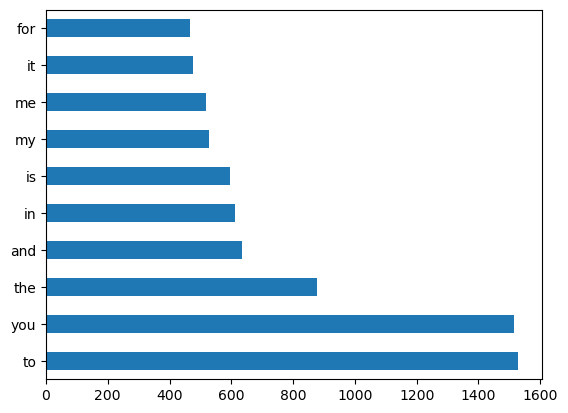

In [22]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

In [23]:
print(CountVectorizer(stop_words='english').get_stop_words())

frozenset({'do', 'give', 'two', 'sincere', 'together', 'an', 'or', 'next', 'my', 'those', 'again', 'been', 'where', 'whose', 'throughout', 'between', 'side', 'find', 'several', 'that', 'call', 'no', 'whereas', 'afterwards', 'their', 'yourself', 'at', 'me', 'such', 'other', 'hundred', 'thereupon', 'yet', 'the', 'am', 'others', 'our', 'fill', 'per', 'because', 'five', 'he', 'onto', 'and', 'cry', 'nine', 'take', 'than', 'three', 'whoever', 'thereafter', 'among', 'hence', 'otherwise', 'nowhere', 'should', 'neither', 'how', 'what', 'without', 'wherever', 'third', 'fifteen', 'here', 'everywhere', 'before', 'ours', 'another', 'somewhere', 'yours', 'else', 'move', 'not', 'few', 'during', 'thru', 'hereupon', 'con', 'fire', 'whole', 'yourselves', 'someone', 'either', 'rather', 'most', 'anyone', 'de', 'whatever', 'describe', 'amongst', 'done', 'towards', 'keep', 'amoungst', 'its', 'who', 'cannot', 'has', 'last', 'eleven', 're', 'go', 'from', 'nevertheless', 'ten', 'you', 'even', 'which', 'might',

<details><summary>What do you think of the top 10 words?</summary>

- These are pretty much all stop words!
- Using a bag-of-words approach with these words in there might not add anything meaningful to our analysis.
</details>

In [24]:
# Let's look at sklearn's stopwords.
print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'do', 'give', 'two', 'sincere', 'together', 'an', 'or', 'next', 'my', 'those', 'again', 'been', 'where', 'whose', 'throughout', 'between', 'side', 'find', 'several', 'that', 'call', 'no', 'whereas', 'afterwards', 'their', 'yourself', 'at', 'me', 'such', 'other', 'hundred', 'thereupon', 'yet', 'the', 'am', 'others', 'our', 'fill', 'per', 'because', 'five', 'he', 'onto', 'and', 'cry', 'nine', 'take', 'than', 'three', 'whoever', 'thereafter', 'among', 'hence', 'otherwise', 'nowhere', 'should', 'neither', 'how', 'what', 'without', 'wherever', 'third', 'fifteen', 'here', 'everywhere', 'before', 'ours', 'another', 'somewhere', 'yours', 'else', 'move', 'not', 'few', 'during', 'thru', 'hereupon', 'con', 'fire', 'whole', 'yourselves', 'someone', 'either', 'rather', 'most', 'anyone', 'de', 'whatever', 'describe', 'amongst', 'done', 'towards', 'keep', 'amoungst', 'its', 'who', 'cannot', 'has', 'last', 'eleven', 're', 'go', 'from', 'nevertheless', 'ten', 'you', 'even', 'which', 'might',

`CountVectorizer` gives you the option to eliminate stopwords from your corpus when instantiating your vectorizer.

```python
cvec = CountVectorizer(stop_words='english')
```

You can optionally pass your own list of stopwords that you'd like to remove.
```python
cvec = CountVectorizer(stop_words=['list', 'of', 'words', 'to', 'stop'])
```

### Vocabulary size

---
One downside to `CountVectorizer` is the size of its vocabulary (`cvec.get_feature_names()`) can get really large. We're creating one column for every unique token in your corpus of data!

There are three hyperparameters to help you control this.

1. You can set `max_features` to only include the $N$ most popular vocabulary words in the corpus.

```python
cvec = CountVectorizer(max_features=1_000) # Only the top 1,000 words from the entire corpus will be saved
```

2. You can tell `CountVectorizer` to only consider words that occur in **at least** some number of documents.

```python
cvec = CountVectorizer(min_df=2) # A word must occur in at least two documents from the corpus
```

3. Conversely, you can tell `CountVectorizer` to only consider words that occur in **at most** some percentage of documents.

```python
cvec = CountVectorizer(max_df=.98) # Ignore words that occur in > 98% of the documents from the corpus
```

Both `max_df` and `min_df` can accept either an integer or a float.
- An integer tells us the number of documents.
- A float tells us the percentage of documents.

<details><summary>Why might we want to control these vocabulary size hyperparameters?</summary>
    
- If we have too many features, our models may take a **very** long time to fit.
- Control for overfitting/underfitting.
- Words in 99% of documents or words occuring in only one document might not be very informative.
</details>

### N-Gram Range
---

`CountVectorizer` has the ability to capture $n$-word phrases, also called $n$-grams. Consider the following:

> The quick brown fox jumped over the lazy dog.

In the example sentence, the 2-grams are:
- 'the quick'
- 'quick brown'
- 'brown fox'
- 'fox jumped'
- 'jumped over'
- 'over the'
- 'the lazy'
- 'lazy dog'

The `ngram_range` determines what $n$-grams should be considered as features.

```python
cvec = CountVectorizer(ngram_range=(1,2)) # Captures every 1-gram and every 2-gram
```

<details><summary>How many 3-grams would be generated from the phrase "the quick brown fox jumped over the lazy dog?"</summary>

- Seven 3-grams.
    - 'the quick brown'
    - 'quick brown fox'
    - 'brown fox jumped'
    - 'fox jumped over'
    - 'jumped over the'
    - 'over the lazy'
    - 'the lazy dog'
</details>

<details><summary>Why might we want to change ngram_range to something other than (1,1)?</summary>

- We can work with multi-word phrases like "not good" or "very hot."
</details>

# Modeling

---

We may want to test lots of different values of hyperparameters in our CountVectorizer.

<details><summary>Is CountVectorizer an estimator or a transformer?</summary>
    
- A transformer.
</details>

<details><summary>Why do we need a pipeline to GridSearch over our CountVectorizer hyperparameters?</summary>
    
- The CountVectorizer is a transformer.
- Transformers have .fit() and .transform() methods, but cannot do .predict().
- In order to GridSearch over hyperparameters, we need some way to score our model performance.
- A pipeline stacks together one or more transformers with an estimator at the end. The estimator allows us to .predict() and get a score!
</details>

In [25]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## Baseline accuracy

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality class).

In [26]:
y_test.value_counts(normalize=True)

0    0.865688
1    0.134312
Name: label, dtype: float64

## Naïve Bayes

I am only going to scratch the surface of this algorithm. For more details on it, check out the resources in the [README](../README.md)!

Naïve Bayes relies on [Bayes theorem](https://www.mathsisfun.com/data/bayes-theorem.html), which we will officially cover in a later week. Right now, just know that we rely on our prior knowledge to calculate probabilities.

In order to understand Bayes theorem, we need to remember conditional probabilities. A quick example to understand this intuitively:

<details><summary>If you pick a card from a standard 52-card deck, what is the probability of drawing a queen given the card is a heart?</summary>
    
I have told you the condition: that the card is a heart. Therefore, we only have 13 options to choose from, since there are 13 hearts in a deck of cards. Out of these, only 1 card is a queen (there is one queen in each suit), so the probability of drawing a queen given the card is a heart is 1/13.
    
It is important to note here that the probability of drawing a queen given the card is a heart is not the same as the probability of drawing a heart given the card is a queen! This would be 1/4.
</details>

If we know $P(B|A)$, Bayes theorem allows us to calculate the probability of $P(A|B)$ by relating the probability of $P(A|B)$ to $P(B|A)$. 

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that a message is spam.
- Let $B$ represent the words used in the message.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{message is spam}|\text{words in message}) &=& \frac{P(\text{words in message}|\text{message is spam})P(\text{message is spam})}{P(\text{words in message})}
\end{eqnarray*}
$$

We want to calculate the probability that a post is spam **given** the words that are in the message! Our model can learn this from the training data.

**Naïve Bayes** makes the assumption that all features are independent of one another (this is why it is called *naïve*).

<details><summary>Why is this assumption not realistic with our data?</summary>
    
Text data is never independent! Certain words can change the context of a sentence when used with other words. The way language works, we have words that are more or less likely to follow other words.
</details>

Despite this assumption not being realistic with NLP data, we still use Naïve Bayes pretty frequently.
- It's a very fast modeling algorithm (which is great especially when we have lots of features and/or lots of data!).
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have 0/1 variables.
    - [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our variables are positive integers.
    - [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.

In [ ]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)



## `GridSearchCV`
---

At this point, you could use your `pipeline` object as a model:

```python
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
pipe.score(X_train, y_train)

# Test score
pipe.score(X_test, y_test)
```

Since we want to tune over the `CountVectorizer`, we'll load our `pipeline` object into `GridSearchCV`.

In [ ]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {}

In [ ]:
# Instantiate GridSearchCV.

gs = GridSearchCV(, # what object are we optimizing?
                  , # what parameters values are we searching?
                  ) # 5-fold cross-validation.

<details><summary>How many models are we fitting here?</summary>

- 4 max_features
- 2 min_df
- 2 max_df
- 2 ngram_range
- 5-fold CV
- 4 * 2 * 2 * 2 * 5 = 160 models
</details>

In [ ]:
# Fit GridSearch to training data.


In [ ]:
# What's the best score?


In [ ]:
# Score model on training set.


In [ ]:
# Score model on testing set.


<details><summary>Is accuracy the best score here?</summary>

Since we are classifying whether or not a message is spam, I care more about minimizing false positives here (maximizing for specificity). I prefer for my important emails to go to my inbox (true negatives) and potentially have a few spam messages go to my inbox (false negative) than miss an important email that was incorrectly classified as spam (false positive). 
</details>

In [ ]:
# Get predictions

# Save confusion matrix values


In [ ]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
# Calculate the specificity


Congratulations! We've used `CountVectorizer` to transform our text data into something we can pass into a model.

But what if we want to do something more than just count up the occurrence of each token?

## Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

---

When modeling, which word do you think tends to be the most helpful?
- Words that are common across all documents.
- Words that are rare across all documents.
- Words that are rare across some documents, and common across some documents.

<details><summary>Answer:</summary>

- Words that are common in certain documents but rare in other documents tend to be more informative than words that are common in all documents or rare in all documents.
- Example: If we were examining poetry over time, the word "thine" might be common in some documents but rare in most documents. The word "thine" is probably pretty informative in this case.
</details>

TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

Variations of the TF-IDF score are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
- If you want to see how it can be calculated, check out [the Wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and [`sklearn`](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting) page.

<img src="./images/tfidfvectorizer.png" alt="drawing" width="750"/>

[Source](https://towardsdatascience.com/nlp-learning-series-part-2-conventional-methods-for-text-classification-40f2839dd061).

### Practice Using the `TfidfVectorizer`

---

`sklearn` provides a TF-IDF vectorizer that works similarly to the CountVectorizer.
- The arguments `stop_words`, `max_features`, `min_df`, `max_df`, and `ngram_range` also work here.

As you did above, instantiate the default `TfidfVectorizer`, then fit the spam and ham data.

In [ ]:
# Instantiate the transformer.
tvec =

Let's visualize the top words.

In [ ]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

### Modeling Using the `TfidfVectorizer`

Let's set up a pipeline using tf-idf and Multinomial Naive Bayes.

<details><summary>What's the problem with this?</summary>

- Technically, we are supposed to have positive integers to use Multinomial Naive Bayes. Tf-idf does not give us positive integers.
- However, it will still work. Even the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) says "The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."
</details>

In [ ]:
# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)


In [ ]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).


In [ ]:
# Instantiate GridSearchCV.


In [ ]:
# Fit GridSearch to training data.


In [ ]:
# Score model on training set.


In [ ]:
# Score model on testing set.


In [ ]:
# Get predictions

# Save confusion matrix values

# Calculate the specificity


## (BONUS) How is the information from vectorizers stored efficiently?

When you CountVectorize the training text messages, you get 3,733 rows and 6,935 features... this is 25,888,355 entries. That's a lot of data to store in a dataframe!

<details><summary>How many of these values are zero?</summary>

- Over 99% of all values are zero!
</details>

Instead of storing all those zeroes, `sklearn` automatically stores these as a sparse matrix. It saves **a lot** of space.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec = CountVectorizer()

X_train = cvec.fit_transform(X_train)

print(type(X_train))
print(X_train[0])